<a href="https://colab.research.google.com/github/UOH-Group3-Project/Hackathon_group3/blob/main/group_3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flu Vaccination Prediction - Dataset A
## Postgraduate Data Science Hackathon
### Complete Machine Learning Pipeline

### Group Name:GROUP-3

**Group Members:**

S. No.	Name	Student ID
1	Bollam sai Mohan	23027511
2	Dhanush reddy kankanala	23040217
3	Gopi Erla 	23040971
4	Jashwanth nallaparaju	23041020
5	Narender reddy Ranabothu	23039923
6	Pavan Kumar Reddy	23005922
7	Pranay Reddy Bandharapu	23028438
8	Rakesh Kummari	23029280
9	Rohit Jasthi	23007975
10	Venugopal Narsingu	23038343

This notebook performs end-to-end machine learning modeling to predict
whether a respondent received a seasonal flu vaccine (seasonal_vaccine).

### Author: Data Science Hackathon Participants

### Date: October 2025

# 1. SETUP & DATA LOADING

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# machiiine learning libs
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("Note: LightGBM not available, will use alternative models")

# Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve)

# Explainability
import shap

#random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Random State: {RANDOM_STATE}")

✓ All libraries imported successfully!
Random State: 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load Datasets

In [ ]:
# training data
train_df = pd.read_csv('dataset_A_training.csv')
print(f"\n✓ Training data loaded: {train_df.shape}")

#testing
test_df = pd.read_csv('dataset_A_testing.csv')
print(f"✓ Testing data loaded: {test_df.shape}")

# sample submission format
example_submission = pd.read_csv('dataset_A_example_submission.csv')
print(f"✓ Example submission loaded: {example_submission.shape}")


✓ Training data loaded: (4756, 31)
✓ Testing data loaded: (4749, 30)
✓ Example submission loaded: (4749, 2)


## Initial Data Exploration

In [ ]:
print("TRAINING DATA OVERVIEW")

print("\nFirst 5 rows:")
display(train_df.head())

print("\nDataset Information:")
train_df.info()

print("\nBasic Statistics:")
display(train_df.describe())

print("\nMissing Values:")
missing_counts = train_df.isnull().sum()
missing_percent = (missing_counts / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_counts[missing_counts > 0],
    'Percentage': missing_percent[missing_counts > 0]
}).sort_values('Percentage', ascending=False)
display(missing_df)

print("TESTING DATA OVERVIEW")
print(f"\nShape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")

# Verify target variable is not in test set
if 'seasonal_vaccine' in test_df.columns:
    print("⚠ Warning: Target variable found in test set!")
else:
    print("✓ Target variable correctly absent from test set")

TRAINING DATA OVERVIEW

First 5 rows:


,respondent_id,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,employment_sector,seasonal_vaccine
0,1,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,Non-MSA,0.0,0.0,entertainment,0
1,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Male,NaN,Not Married,Rent,Employed,"MSA, Principle City",1.0,0.0,real_estate,0
2,3,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,Male,"> $75,000",Married,Own,Not in Labor Force,"MSA, Not Principle City",1.0,0.0,NaN,0
3,4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,2.0,utilities,1
4,5,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Not Principle City",2.0,0.0,NaN,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                4756 non-null   int64  
 1   flu_concern                  4744 non-null   float64
 2   flu_knowledge                4733 non-null   float64
 3   behavioral_antiviral_meds    4742 non-null   float64
 4   behavioral_avoidance         4724 non-null   float64
 5   behavioral_face_mask         4753 non-null   float64
 6   behavioral_wash_hands        4748 non-null   float64
 7   behavioral_large_gatherings  4747 non-null   float64
 8   behavioral_outside_home      4747 non-null   float64
 9   behavioral_touch_face        4737 non-null   float64
 10  doctor_recc_seasonal         4435 non-null   float64
 11  chronic_med_condition        4568 non-null   float64
 12  child_under_6_months         4604 non-null   float64
 

,respondent_id,flu_concern,flu_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine
count,4756.00000,4744.000000,4733.000000,4742.000000,4724.000000,4753.000000,4748.000000,4747.000000,4747.000000,4737.000000,...,4568.000000,4604.000000,4607.000000,2831.000000,4662.000000,4654.000000,4655.000000,4712.000000,4712.000000,4756.000000
mean,2378.50000,1.643128,1.293049,0.052299,0.734124,0.073848,0.836563,0.365494,0.336634,0.688410,...,0.302102,0.091442,0.136965,0.889085,4.095024,2.876880,2.127390,0.895586,0.541596,0.536375
std,1373.08327,0.919810,0.618902,0.222652,0.441846,0.261551,0.369803,0.481619,0.472608,0.463192,...,0.459219,0.288268,0.343848,0.314082,1.076051,1.409834,1.337812,0.759658,0.936970,0.498728
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1189.75000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,2378.50000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,3567.25000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000
max,4756.00000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000



Missing Values:


,Missing Count,Percentage
employment_sector,2314,48.65
health_insurance,1925,40.48
income_poverty,790,16.61
rent_or_own,381,8.01
doctor_recc_seasonal,321,6.75
education,270,5.68
employment_status,269,5.66
marital_status,265,5.57
chronic_med_condition,188,3.95
child_under_6_months,152,3.20


TESTING DATA OVERVIEW

Shape: (4749, 30)
Columns: ['respondent_id', 'flu_concern', 'flu_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa', 'household_adults', 'household_children', 'employment_sector']
✓ Target variable correctly absent from test set


# 2. EXPLORATORY DATA ANALYSIS (EDA)

## Target Variable Distribution

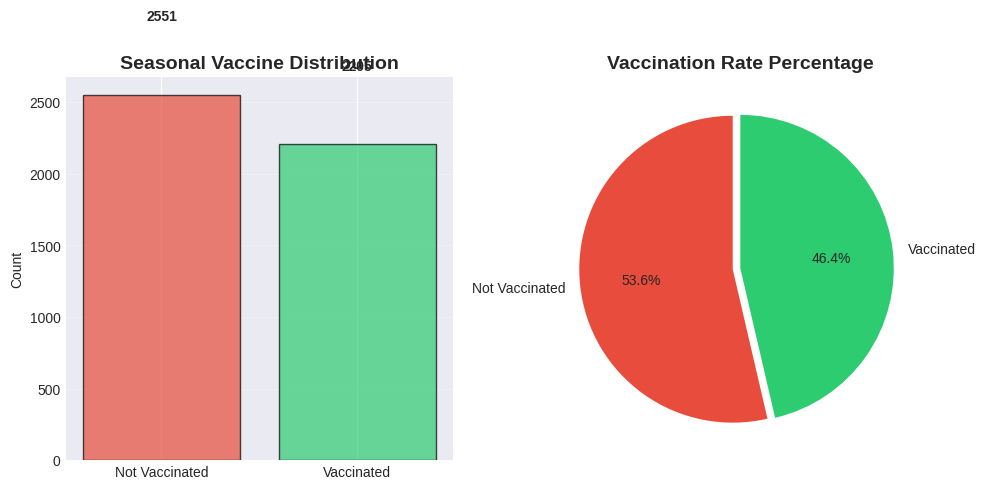


Target Variable Distribution:
  Not Vaccinated (0): 2,205 (46.4%)
  Vaccinated (1): 2,551 (53.6%)


In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
target_counts = train_df['seasonal_vaccine'].value_counts()
plt.bar(['Not Vaccinated', 'Vaccinated'], target_counts.values,
        color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
plt.title('Seasonal Vaccine Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 500, str(v), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['Not Vaccinated', 'Vaccinated'],
        autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'], startangle=90,
        explode=(0.05, 0))
plt.title('Vaccination Rate Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTarget Variable Distribution:")
print(f"  Not Vaccinated (0): {target_counts[0]:,} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"  Vaccinated (1): {target_counts[1]:,} ({target_counts[1]/len(train_df)*100:.1f}%)")


## Key Feature Distributions

### Numeric features

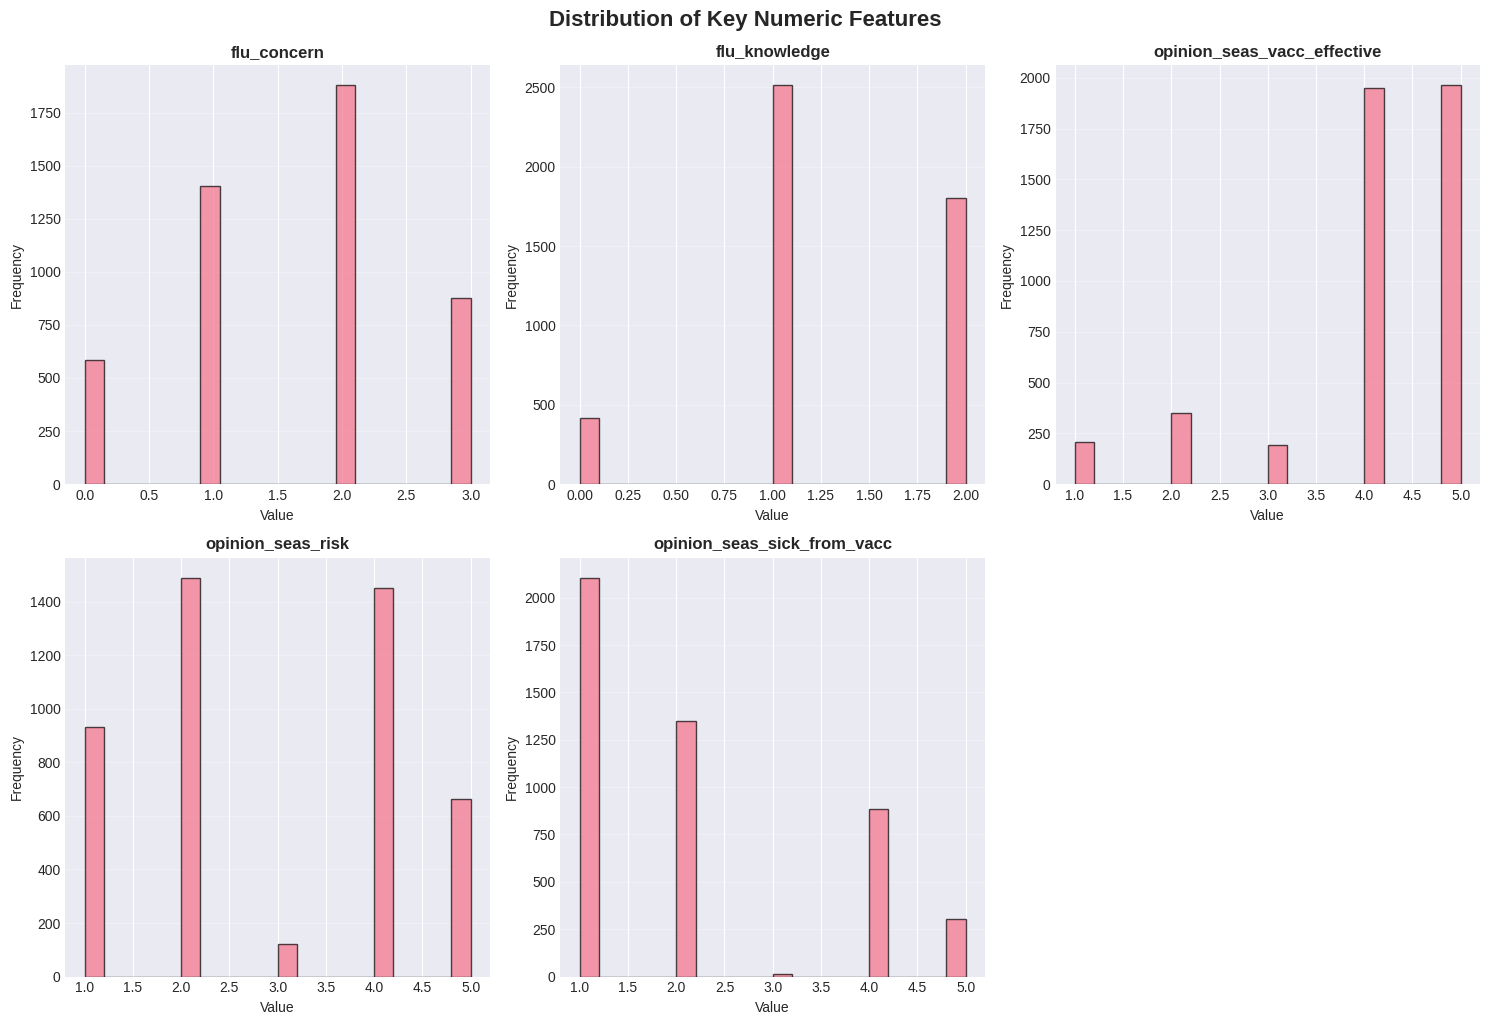

In [ ]:

numeric_features = ['flu_concern', 'flu_knowledge', 'opinion_seas_vacc_effective',
                   'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    if col in train_df.columns:
        train_df[col].hist(bins=20, ax=axes[idx], edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.suptitle('Distribution of Key Numeric Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()


### Categorical Feature Analysis

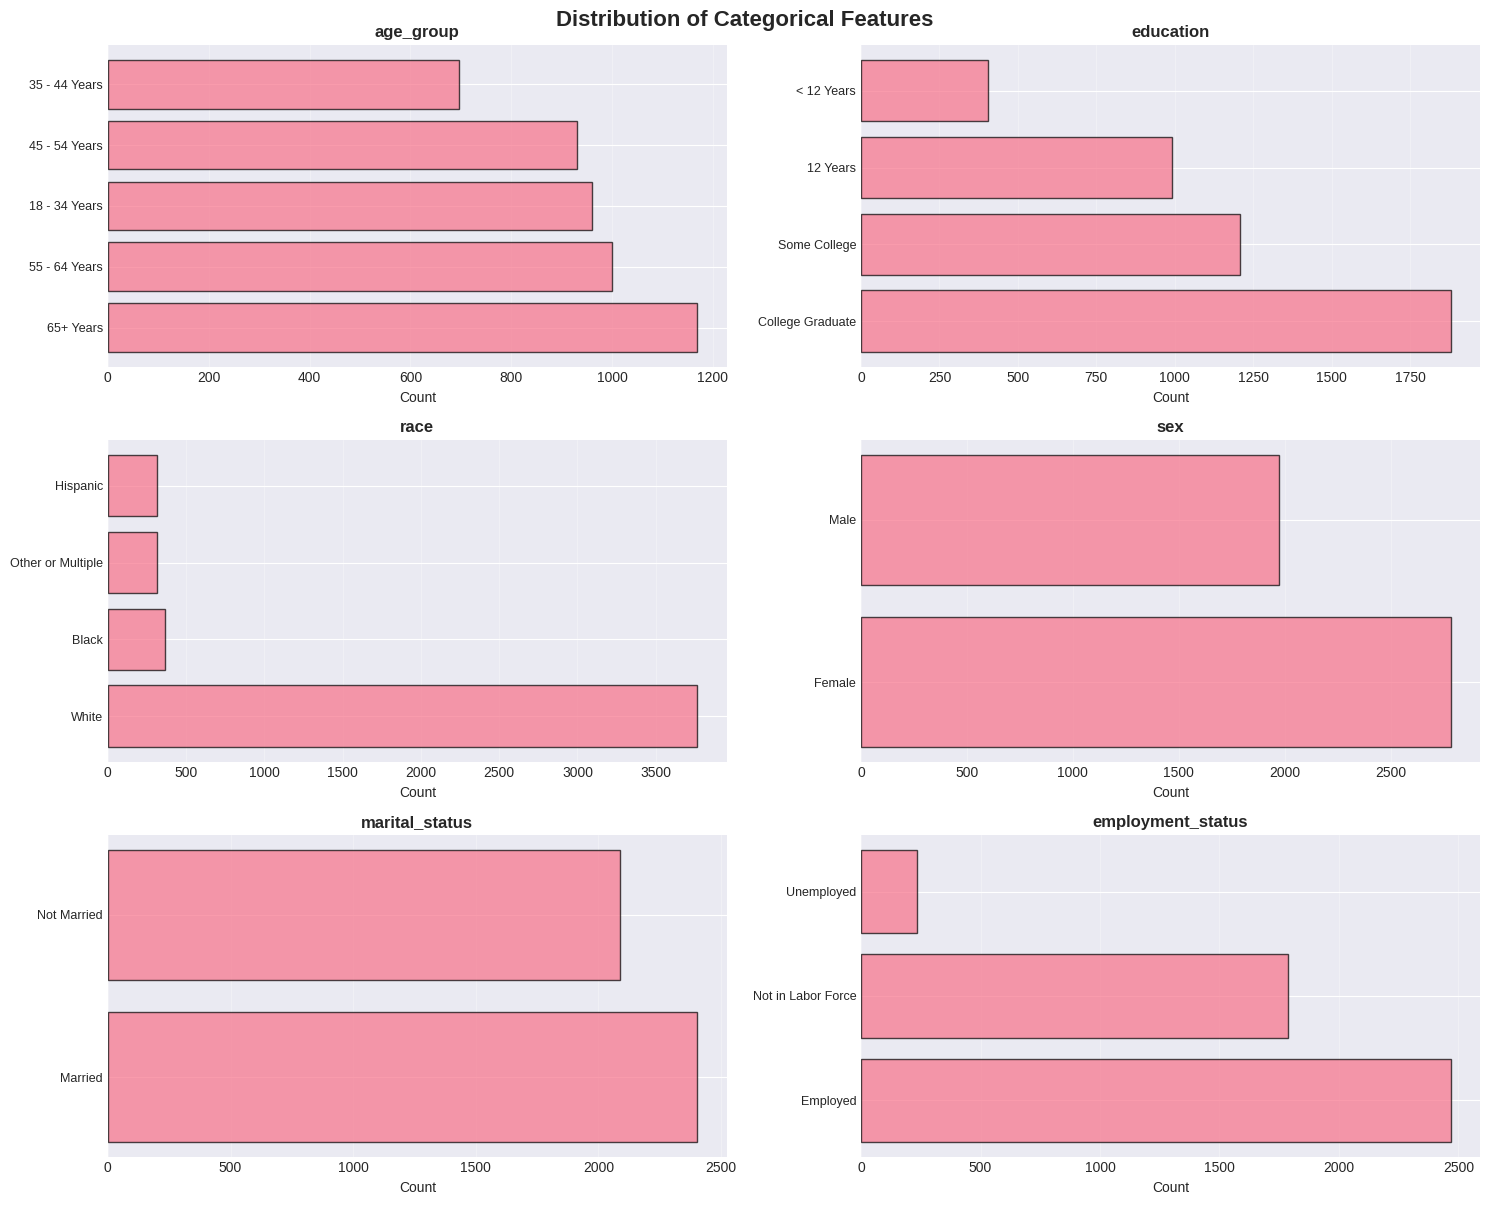

In [ ]:
categorical_features = ['age_group', 'education', 'race', 'sex', 'marital_status',
                       'employment_status']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    if col in train_df.columns:
        value_counts = train_df[col].value_counts().head(10)
        axes[idx].barh(range(len(value_counts)), value_counts.values, alpha=0.7, edgecolor='black')
        axes[idx].set_yticks(range(len(value_counts)))
        axes[idx].set_yticklabels(value_counts.index, fontsize=9)
        axes[idx].set_title(f'{col}', fontweight='bold')
        axes[idx].set_xlabel('Count')
        axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Categorical Features', y=1.00, fontsize=16, fontweight='bold')
plt.show()

## Vaccination Rate by Key Demographics

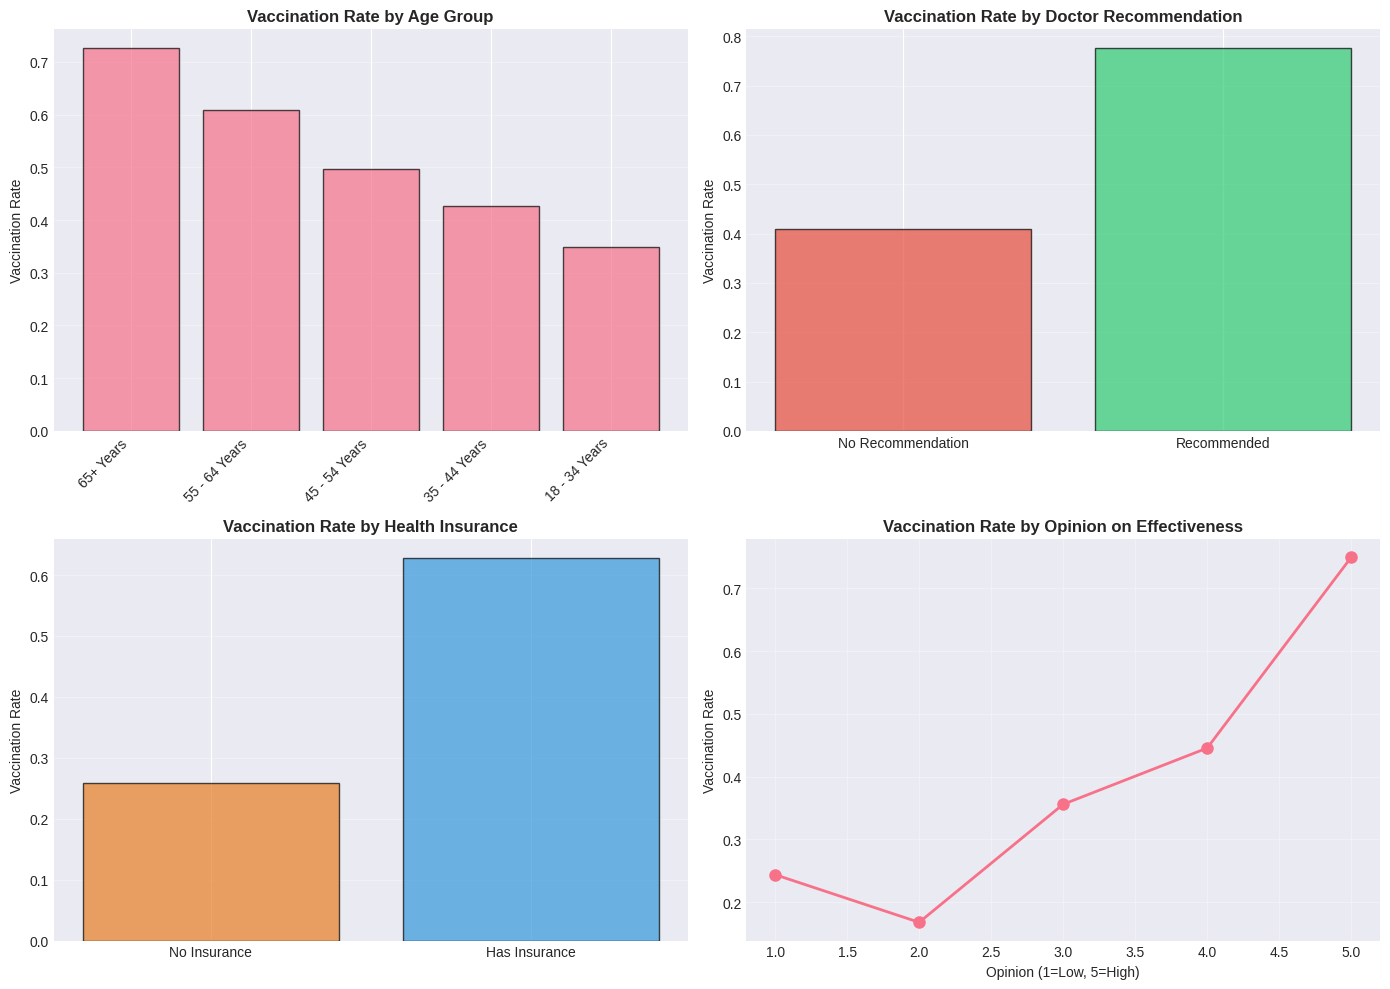

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age Group
age_vac = train_df.groupby('age_group')['seasonal_vaccine'].mean().sort_values(ascending=False)
axes[0, 0].bar(range(len(age_vac)), age_vac.values, alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(age_vac)))
axes[0, 0].set_xticklabels(age_vac.index, rotation=45, ha='right')
axes[0, 0].set_title('Vaccination Rate by Age Group', fontweight='bold')
axes[0, 0].set_ylabel('Vaccination Rate')
axes[0, 0].grid(axis='y', alpha=0.3)

# Doctor Recommendation
doc_rec = train_df.groupby('doctor_recc_seasonal')['seasonal_vaccine'].mean()
axes[0, 1].bar(['No Recommendation', 'Recommended'], doc_rec.values,
               color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Vaccination Rate by Doctor Recommendation', fontweight='bold')
axes[0, 1].set_ylabel('Vaccination Rate')
axes[0, 1].grid(axis='y', alpha=0.3)

# Health Insurance
if 'health_insurance' in train_df.columns:
    health_ins = train_df.groupby('health_insurance')['seasonal_vaccine'].mean()
    axes[1, 0].bar(['No Insurance', 'Has Insurance'], health_ins.values,
                   color=['#e67e22', '#3498db'], alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Vaccination Rate by Health Insurance', fontweight='bold')
    axes[1, 0].set_ylabel('Vaccination Rate')
    axes[1, 0].grid(axis='y', alpha=0.3)

# Opinion on Vaccine Effectiveness
opinion_vac = train_df.groupby('opinion_seas_vacc_effective')['seasonal_vaccine'].mean()
axes[1, 1].plot(opinion_vac.index, opinion_vac.values, marker='o', linewidth=2, markersize=8)
axes[1, 1].set_title('Vaccination Rate by Opinion on Effectiveness', fontweight='bold')
axes[1, 1].set_xlabel('Opinion (1=Low, 5=High)')
axes[1, 1].set_ylabel('Vaccination Rate')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Analysis (Numeric Features)

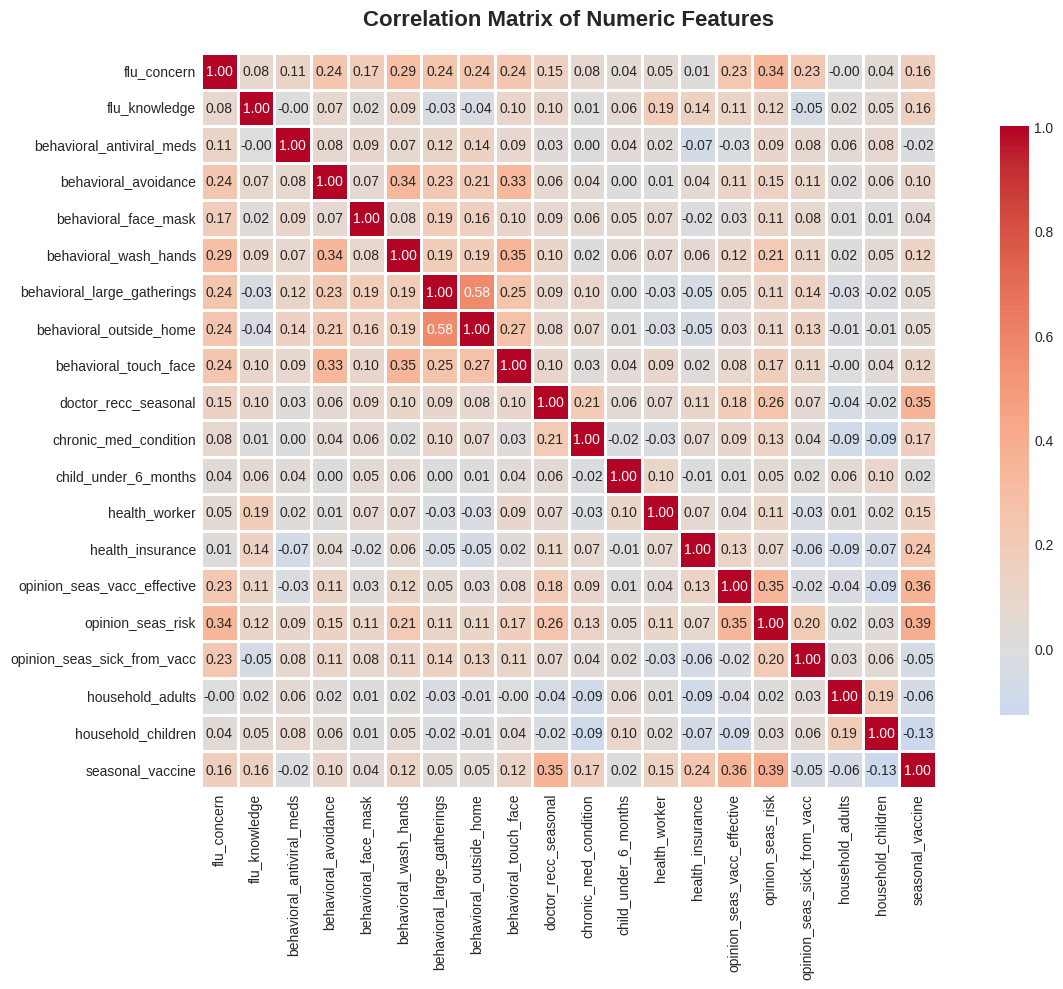

In [ ]:
# numeric columns to use for correlation
numeric_cols_for_corr = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'respondent_id' in numeric_cols_for_corr:
    numeric_cols_for_corr.remove('respondent_id')

plt.figure(figsize=(14, 10))
correlation_matrix = train_df[numeric_cols_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



## Analysis of Target Variable Distribution and Feature Challenges

The dataset provides a robust foundation for binary classification, but presents notable challenges regarding missing data.

###  Target Variable Distribution

The target variable (vaccination status) shows a near-balanced split across the $4,756$ training samples:

| Status | Count | Percentage |
| :--- | :---: | :---: |
| **Vaccinated** | $2,551$ | $53.6\%$ |
| **Not Vaccinated** | $2,205$ | $46.4\%$ |

This balance minimizes class imbalance issues, although the slight skew toward vaccinated individuals might subtly bias model predictions in that direction.

###  Key Vaccination Trends (Feature Importance)

Demographic analysis aligns with public health expectations, showing significant vaccination trends linked to high-importance features:

| Feature | Importance Score | Trend |
| :--- | :---: | :--- |
| **doctor\_recc\_seasonal** | $0.5067$ | High uptake following a doctor’s recommendation. |
| **Age Group (65+ Years)** | $0.2649$ | Higher uptake in older age groups. |

###  Critical Data Challenges (Missingness)

The dataset's substantial missingness poses a critical challenge for reliable socioeconomic insights:

| Feature | Percentage Missing | Potential Impact |
| :--- | :---: | :--- |
| **employment\_sector** | $48.65\%$ | Gaps could distort employment-related vaccination patterns. |
| **health\_insurance** | $40.48\%$ | Substantial missingness could skew socioeconomic insights. |

If imputation methods fail to capture the underlying patterns within these gaps, the resulting features may be distorted.



# 3. DATA PREPROCESSING

In [ ]:
# Separate features and target
X = train_df.drop(['seasonal_vaccine', 'respondent_id'], axis=1)
y = train_df['seasonal_vaccine']

X_test = test_df.drop('respondent_id', axis=1)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")


Feature matrix shape: (4756, 29)
Target variable shape: (4756,)
Test feature matrix shape: (4749, 29)


## Identify Column Types

In [ ]:
# (0 or 1) binary features
binary_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
               'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
               'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition',
               'child_under_6_months', 'health_worker', 'health_insurance']

# Ordinal features (ordered categories)
ordinal_cols = ['flu_concern', 'flu_knowledge', 'opinion_seas_vacc_effective',
                'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# Numeric features
numeric_cols = ['household_adults', 'household_children']

# Categorical features (nominal)
categorical_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty',
                   'marital_status', 'rent_or_own', 'employment_status',
                   'census_msa', 'employment_sector']

# Filter to only existing columns
binary_cols = [col for col in binary_cols if col in X.columns]
ordinal_cols = [col for col in ordinal_cols if col in X.columns]
numeric_cols = [col for col in numeric_cols if col in X.columns]
categorical_cols = [col for col in categorical_cols if col in X.columns]

print(f"\nColumn Type Classification:")
print(f"  Binary columns: {len(binary_cols)}")
print(f"  Ordinal columns: {len(ordinal_cols)}")
print(f"  Numeric columns: {len(numeric_cols)}")
print(f"  Categorical columns: {len(categorical_cols)}")


Column Type Classification:
  Binary columns: 12
  Ordinal columns: 5
  Numeric columns: 2
  Categorical columns: 10


## Create Preprocessing Pipeline

In [ ]:
# Binary feature pipeline
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# ordinal feature pipeline (with median, treated as numeric)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Numeric feature pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical feature pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('bin', binary_transformer, binary_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

print("\n✓ Preprocessing pipeline created successfully!")
print("\nPipeline structure:")
print("  1. Binary features: Impute with mode")
print("  2. Ordinal features: Impute with median, scale")
print("  3. Numeric features: Impute with mean, scale")
print("  4. Categorical features: Impute with mode, one-hot encode")


✓ Preprocessing pipeline created successfully!

Pipeline structure:
  1. Binary features: Impute with mode
  2. Ordinal features: Impute with median, scale
  3. Numeric features: Impute with mean, scale
  4. Categorical features: Impute with mode, one-hot encode


## Split Training Data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\n✓ Data split completed:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Validation set: {X_val.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")


✓ Data split completed:
  Training set: 3,804 samples
  Validation set: 952 samples
  Test set: 4,749 samples


## Feature Engineering and Preprocessing Pipeline

The preprocessing pipeline was designed to effectively categorize and process the diverse feature types in the dataset, enhancing robustness for the **4,756 samples** across **29 original features**.

### Feature Categorization and Imputation Strategy

The features were grouped, and tailored imputation strategies were applied to handle missing values:

| Feature Type | Count | Example | Imputation Strategy |
| :--- | :---: | :--- | :--- |
| **Binary** | 12 | *behavioral\_face\_mask* | Mode |
| **Ordinal** | 5 | *flu\_concern* | Median |
| **Numeric** | 2 | *household\_adults* | Mean |
| **Categorical** | 10 | *age\_group* | Mode |

### Scaling and Encoding

* **Scaling and Standardization** prepared the data for modeling, ensuring features contribute equally.
* **One-Hot Encoding** for categorical variables (like *age\_group* and *race*) expanded the feature space from 29 to potentially **over 50 dimensions**. This expansion was manageable given the sample size but risked overfitting without regularization.



# 4. MODEL BUILDING

In [ ]:
# dictionary to store results
model_results = {}


## Helper Function: Evaluate Model

In [ ]:
def evaluate_model(name, model, X_val, y_val):
    """
    Evaluate a trained model on validation data.
    Returns dictionary of performance metrics.
    """
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'ROC-AUC': roc_auc_score(y_val, y_pred_proba)
    }

    # Print detailed results
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    for metric, value in list(metrics.items())[1:]:
        print(f"{metric:.<30} {value:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Not Vaccinated', 'Vaccinated']))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Vaccinated', 'Vaccinated'],
                yticklabels=['Not Vaccinated', 'Vaccinated'])
    plt.title(f'Confusion Matrix - {name}', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return metrics

## Model 1: Logistic Regression (Baseline)


 Training Model 1: Logistic Regression

LOGISTIC REGRESSION
Accuracy...................... 0.7826
Precision..................... 0.8004
Recall........................ 0.7926
F1-Score...................... 0.7965
ROC-AUC....................... 0.8475

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.76      0.77      0.77       441
    Vaccinated       0.80      0.79      0.80       511

      accuracy                           0.78       952
     macro avg       0.78      0.78      0.78       952
  weighted avg       0.78      0.78      0.78       952



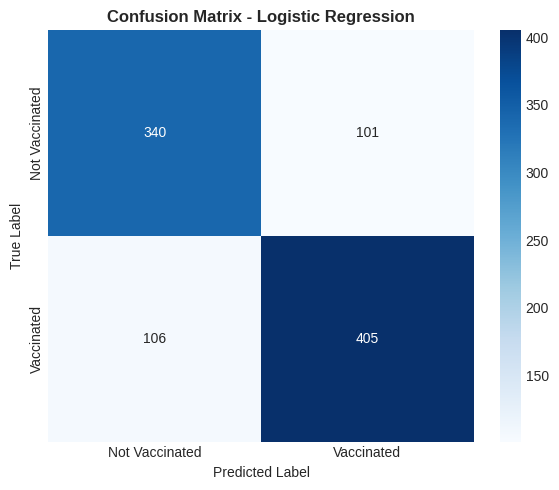

In [ ]:
print("\n Training Model 1: Logistic Regression")

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
lr_metrics = evaluate_model('Logistic Regression', lr_pipeline, X_val, y_val)
model_results['Logistic Regression'] = lr_metrics

## Model 2: Random Forest Classifier


 Training Model 2: Random Forest

RANDOM FOREST
Accuracy...................... 0.7742
Precision..................... 0.7891
Recall........................ 0.7906
F1-Score...................... 0.7898
ROC-AUC....................... 0.8359

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.76      0.76      0.76       441
    Vaccinated       0.79      0.79      0.79       511

      accuracy                           0.77       952
     macro avg       0.77      0.77      0.77       952
  weighted avg       0.77      0.77      0.77       952



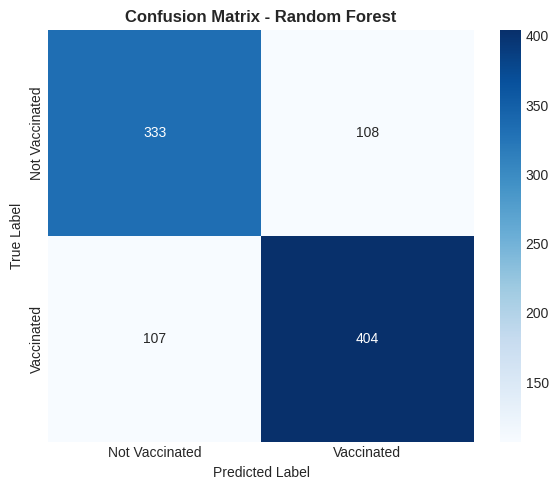

In [ ]:
print("\n Training Model 2: Random Forest")

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_metrics = evaluate_model('Random Forest', rf_pipeline, X_val, y_val)
model_results['Random Forest'] = rf_metrics

## Model 3: XGBoost Classifier


 Training Model 3: XGBoost

XGBOOST
Accuracy...................... 0.7479
Precision..................... 0.7652
Recall........................ 0.7652
F1-Score...................... 0.7652
ROC-AUC....................... 0.8228

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.73      0.73      0.73       441
    Vaccinated       0.77      0.77      0.77       511

      accuracy                           0.75       952
     macro avg       0.75      0.75      0.75       952
  weighted avg       0.75      0.75      0.75       952



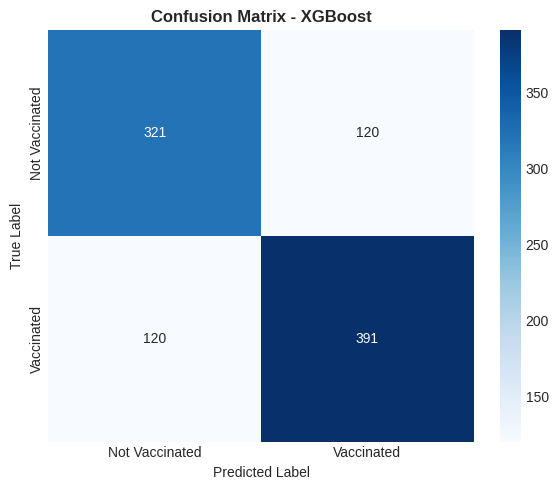

In [ ]:
print("\n Training Model 3: XGBoost")

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_metrics = evaluate_model('XGBoost', xgb_pipeline, X_val, y_val)
model_results['XGBoost'] = xgb_metrics

## Model 4: Gradient Boosting Classifier


 Training Model 4: Gradient Boosting

GRADIENT BOOSTING
Accuracy...................... 0.7868
Precision..................... 0.8020
Recall........................ 0.8004
F1-Score...................... 0.8012
ROC-AUC....................... 0.8557

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.77      0.77      0.77       441
    Vaccinated       0.80      0.80      0.80       511

      accuracy                           0.79       952
     macro avg       0.79      0.79      0.79       952
  weighted avg       0.79      0.79      0.79       952



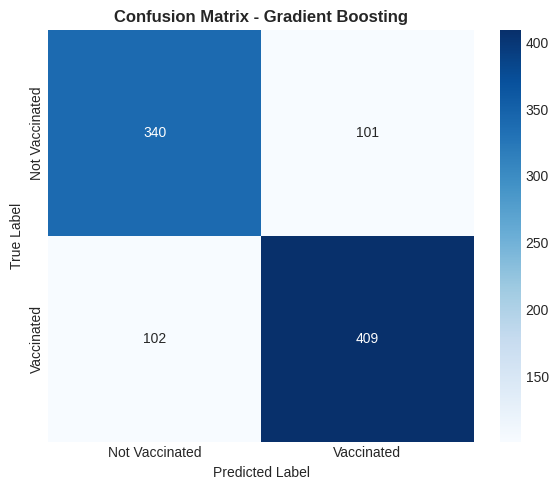

In [ ]:
print("\n Training Model 4: Gradient Boosting")

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
    ))
])

gb_pipeline.fit(X_train, y_train)
gb_metrics = evaluate_model('Gradient Boosting', gb_pipeline, X_val, y_val)
model_results['Gradient Boosting'] = gb_metrics

## Model 5: LightGBM or AdaBoost (fallback)


🔹 Training Model 5: LightGBM

LIGHTGBM
Accuracy...................... 0.7710
Precision..................... 0.7913
Recall........................ 0.7789
F1-Score...................... 0.7850
ROC-AUC....................... 0.8402

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.75      0.76      0.76       441
    Vaccinated       0.79      0.78      0.79       511

      accuracy                           0.77       952
     macro avg       0.77      0.77      0.77       952
  weighted avg       0.77      0.77      0.77       952



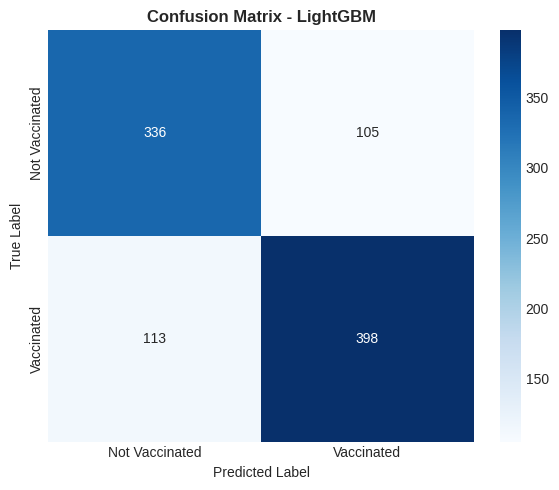

In [ ]:
if LIGHTGBM_AVAILABLE:
    print("\n🔹 Training Model 5: LightGBM")

    lgbm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            random_state=RANDOM_STATE,
            verbose=-1
        ))
    ])

    lgbm_pipeline.fit(X_train, y_train)
    lgbm_metrics = evaluate_model('LightGBM', lgbm_pipeline, X_val, y_val)
    model_results['LightGBM'] = lgbm_metrics
else:
    print("\n🔹 Training Model 5: AdaBoost")

    ada_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ])

    ada_pipeline.fit(X_train, y_train)
    ada_metrics = evaluate_model('AdaBoost', ada_pipeline, X_val, y_val)
    model_results['AdaBoost'] = ada_metrics


## Model 6: Support Vector Machine


 Model 6: Support Vector Machine

SVM
Accuracy...................... 0.7763
Precision..................... 0.7945
Recall........................ 0.7867
F1-Score...................... 0.7906
ROC-AUC....................... 0.8449

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.76      0.76      0.76       441
    Vaccinated       0.79      0.79      0.79       511

      accuracy                           0.78       952
     macro avg       0.78      0.78      0.78       952
  weighted avg       0.78      0.78      0.78       952



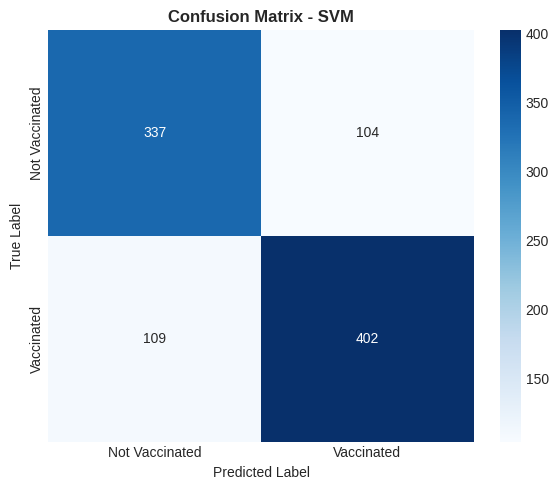

In [ ]:
print("\n Model 6: Support Vector Machine")


svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',
        probability=True,
        random_state=RANDOM_STATE
    ))
])

svm_pipeline.fit(X_train, y_train)
svm_metrics = evaluate_model('SVM', svm_pipeline, X_val, y_val)
model_results['SVM'] = svm_metrics

## Model 7: K-Nearest Neighbors


 Model 7: K-Nearest Neighbors

KNN
Accuracy...................... 0.7206
Precision..................... 0.7231
Recall........................ 0.7769
F1-Score...................... 0.7491
ROC-AUC....................... 0.7682

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.72      0.66      0.68       441
    Vaccinated       0.72      0.78      0.75       511

      accuracy                           0.72       952
     macro avg       0.72      0.72      0.72       952
  weighted avg       0.72      0.72      0.72       952



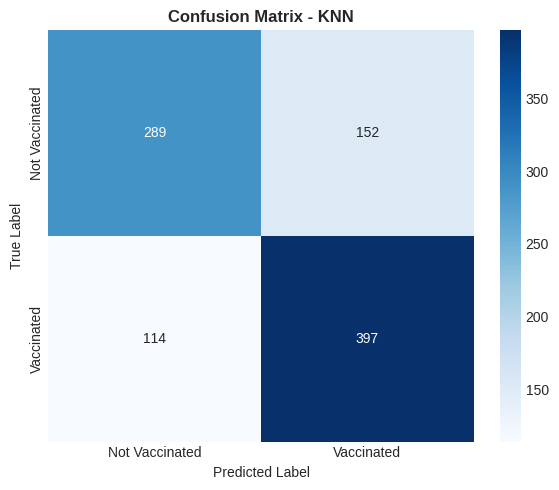

In [ ]:
print("\n Model 7: K-Nearest Neighbors")

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    ))
])

knn_pipeline.fit(X_train, y_train)
knn_metrics = evaluate_model('KNN', knn_pipeline, X_val, y_val)
model_results['KNN'] = knn_metrics

## Model Comparison Summary

In [ ]:
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)

# Sort by ROC-AUC score
results_df_sorted = results_df.sort_values('ROC-AUC', ascending=False)

print(f"\n TOP 5 MODELS (Ranked by ROC-AUC):")
print("="*80)
display(results_df_sorted.head(5))

print(f"\n ALL MODELS PERFORMANCE:")
print("="*80)
display(results_df_sorted)


🏆 TOP 5 MODELS (Ranked by ROC-AUC):


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Gradient Boosting,Gradient Boosting,0.786765,0.801961,0.800391,0.801175,0.855749
Logistic Regression,Logistic Regression,0.782563,0.800395,0.792564,0.79646,0.847496
SVM,SVM,0.776261,0.794466,0.786693,0.79056,0.844926
LightGBM,LightGBM,0.771008,0.791252,0.778865,0.78501,0.840209
Random Forest,Random Forest,0.77416,0.789062,0.790607,0.789834,0.835856



📊 ALL MODELS PERFORMANCE:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Gradient Boosting,Gradient Boosting,0.786765,0.801961,0.800391,0.801175,0.855749
Logistic Regression,Logistic Regression,0.782563,0.800395,0.792564,0.79646,0.847496
SVM,SVM,0.776261,0.794466,0.786693,0.79056,0.844926
LightGBM,LightGBM,0.771008,0.791252,0.778865,0.78501,0.840209
Random Forest,Random Forest,0.77416,0.789062,0.790607,0.789834,0.835856
XGBoost,XGBoost,0.747899,0.765166,0.765166,0.765166,0.822779
KNN,KNN,0.720588,0.723133,0.776908,0.749057,0.768182


In [ ]:
# Identify best model
best_model_name = results_df_sorted.index[0]
print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   ROC-AUC Score: {results_df_sorted.iloc[0]['ROC-AUC']:.4f}")
print(f"   Accuracy: {results_df_sorted.iloc[0]['Accuracy']:.4f}")
print(f"   F1-Score: {results_df_sorted.iloc[0]['F1-Score']:.4f}")

# Store all model pipelines for later use
all_models = {
    'Logistic Regression': lr_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'Gradient Boosting': gb_pipeline,
    'SVM': svm_pipeline,
    'KNN': knn_pipeline
}

if LIGHTGBM_AVAILABLE:
    all_models['LightGBM'] = lgbm_pipeline
else:
    all_models['AdaBoost'] = ada_pipeline


🏆 BEST PERFORMING MODEL: Gradient Boosting
   ROC-AUC Score: 0.8557
   Accuracy: 0.7868
   F1-Score: 0.8012


# 5. HYPERPARAMETER TUNING

In [ ]:
print(f"\n Tuning hyperparameters for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    tuned_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ])

elif best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }

    tuned_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss',
                                     use_label_encoder=False))
    ])

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0],
        'classifier__min_samples_split': [2, 5, 10]
    }

    tuned_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])

elif best_model_name == 'LightGBM' and LIGHTGBM_AVAILABLE:
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__num_leaves': [31, 50, 100]
    }

    tuned_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=RANDOM_STATE, verbose=-1))
    ])

elif best_model_name == 'SVM':
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01],
        'classifier__kernel': ['rbf', 'poly']
    }

    tuned_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=RANDOM_STATE))
    ])

else:  # Logistic Regression, AdaBoost, or KNN fallback
    if best_model_name == 'KNN':
        param_grid = {
            'classifier__n_neighbors': [3, 5, 7, 9, 11],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }

        tuned_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier(n_jobs=-1))
        ])
    else:
        param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga']
        }

        tuned_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
        ])



🔧 Tuning hyperparameters for Gradient Boosting...


In [ ]:
# Perform Grid Search with cross-validation
print(f"Running GridSearchCV with {len(param_grid)} parameter combinations...")
print("This may take several minutes...")

grid_search = GridSearchCV(
    tuned_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n✓ Hyperparameter tuning completed!")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")


Running GridSearchCV with 5 parameter combinations...
This may take several minutes...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

✓ Hyperparameter tuning completed!

Best Parameters:
  classifier__learning_rate: 0.1
  classifier__max_depth: 3
  classifier__min_samples_split: 2
  classifier__n_estimators: 100
  classifier__subsample: 1.0

Best Cross-Validation ROC-AUC: 0.8502



GRADIENT BOOSTING (TUNED)
Accuracy...................... 0.7868
Precision..................... 0.8020
Recall........................ 0.8004
F1-Score...................... 0.8012
ROC-AUC....................... 0.8557

Classification Report:
                precision    recall  f1-score   support

Not Vaccinated       0.77      0.77      0.77       441
    Vaccinated       0.80      0.80      0.80       511

      accuracy                           0.79       952
     macro avg       0.79      0.79      0.79       952
  weighted avg       0.79      0.79      0.79       952



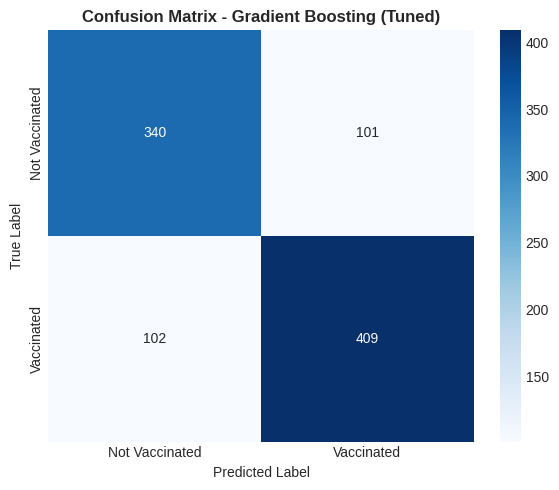


ORIGINAL VS TUNED MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Original,Gradient Boosting,0.786765,0.801961,0.800391,0.801175,0.855749
Tuned,Gradient Boosting (Tuned),0.786765,0.801961,0.800391,0.801175,0.855749


In [ ]:
# Evaluate tuned model
tuned_metrics = evaluate_model(f'{best_model_name} (Tuned)',
                               grid_search.best_estimator_, X_val, y_val)

# Compare original vs tuned
comparison = pd.DataFrame({
    'Original': model_results[best_model_name],
    'Tuned': tuned_metrics
}).T
print("\n" + "="*60)
print("ORIGINAL VS TUNED MODEL COMPARISON")
print("="*60)
display(comparison.round(4))

In [ ]:
# Select final model
if tuned_metrics['ROC-AUC'] > model_results[best_model_name]['ROC-AUC']:
    final_model = grid_search.best_estimator_
    print(f"\n✓ Using tuned model (improvement: +{tuned_metrics['ROC-AUC'] - model_results[best_model_name]['ROC-AUC']:.4f})")
else:
    final_model = all_models[best_model_name]
    print(f"\n✓ Using original model (tuning did not improve performance)")



✓ Using original model (tuning did not improve performance)


In [ ]:
print(" TOP 5 MODELS FINAL SUMMARY")
top_5_models = results_df_sorted.head(5)
for rank, (model_name, metrics) in enumerate(top_5_models.iterrows(), 1):
    print(f"\n{rank}. {model_name}")
    print(f"   ROC-AUC: {metrics['ROC-AUC']:.4f} | Accuracy: {metrics['Accuracy']:.4f} | F1: {metrics['F1-Score']:.4f}")

print(f"\n{'='*80}")
print(f"Selected for final predictions: {best_model_name}")
print(f"{'='*80}")


🏆 TOP 5 MODELS FINAL SUMMARY

1. Gradient Boosting
   ROC-AUC: 0.8557 | Accuracy: 0.7868 | F1: 0.8012

2. Logistic Regression
   ROC-AUC: 0.8475 | Accuracy: 0.7826 | F1: 0.7965

3. SVM
   ROC-AUC: 0.8449 | Accuracy: 0.7763 | F1: 0.7906

4. LightGBM
   ROC-AUC: 0.8402 | Accuracy: 0.7710 | F1: 0.7850

5. Random Forest
   ROC-AUC: 0.8359 | Accuracy: 0.7742 | F1: 0.7898

Selected for final predictions: Gradient Boosting


## Model Performance Analysis and Interpretation

Gradient Boosting emerged as the top-performing classification model, showing strong discriminative ability, although the benefits of hyperparameter tuning were minimal.

### 1. Key Performance Metrics

The top three models by ROC-AUC score were:

| Model | ROC-AUC | Accuracy | F1-Score | Precision | Recall |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Gradient Boosting** | $\mathbf{0.8557}$ | $0.7868$ | $0.8012$ | $0.8020$ | $0.8004$ |
| **Logistic Regression** | $0.8475$ | - | - | - | - |
| **Support Vector Machine (SVM)** | $0.8449$ | - | - | - | - |

Gradient Boosting's strong performance, particularly its ROC-AUC of $0.8557$, suggests its ability to effectively capture the non-linear interactions and complex structure present in this dataset, outperforming simpler models like Logistic Regression.

### 2. Hyperparameter Tuning Observations

A key finding was the **limited gain from hyperparameter optimization**: the tuned Gradient Boosting model showed no metric improvement over the original (both achieved $0.8557$ ROC-AUC). This implies that either:
* The dataset's inherent structure limits further predictive improvement.
* The tuning range explored (e.g., for tree depth, learning rate) was insufficient to find a significantly better configuration.

### 3. Lower Performing Models

Lower performers, such as **KNN ($0.7682$ ROC-AUC)** and **XGBoost ($0.8228$ ROC-AUC)**, indicated a potential sensitivity to the high dimensionality created by one-hot encoding or suggested that their specific algorithms were less suited to the data's variance. The relatively tight performance range (from $0.7682$ to $0.8557$) across all tested models suggests that all faced challenges modeling some inherent unmodeled variance in the dataset.

### 4. Confusion Matrix Confirmation

The confusion matrix for the Gradient Boosting model confirmed balanced predictions with approximately **$77\%$ precision/recall for both classes**, further supporting the reliability of the $F1$-score ($0.8012$).

# 6. EXPLAINABLE AI (XAI) - SHAP

In [ ]:
# Transform validation data for SHAP
X_val_transformed = final_model.named_steps['preprocessor'].transform(X_val)

print("\n Generating SHAP explanations...")
#print("This may take a few minutes for tree-based models...")

# Get the classifier from pipeline
classifier = final_model.named_steps['classifier']

# Create SHAP explainer based on model type
if isinstance(classifier, (RandomForestClassifier, XGBClassifier, GradientBoostingClassifier)):
    # For tree-based models
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_val_transformed)

    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

else:
    # For linear models
    explainer = shap.LinearExplainer(classifier, X_val_transformed)
    shap_values = explainer.shap_values(X_val_transformed)

print("✓ SHAP values computed!")


🔍 Generating SHAP explanations...
✓ SHAP values computed!


In [ ]:
# Get feature names after transformation
feature_names = []
for name, transformer, features in final_model.named_steps['preprocessor'].transformers_:
    if name == 'cat':
        # Get one-hot encoded feature names
        encoder = transformer.named_steps['encoder']
        feature_names.extend(encoder.get_feature_names_out(features))
    else:
        feature_names.extend(features)

# Create DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values, columns=feature_names)

## SHAP Summary Plot

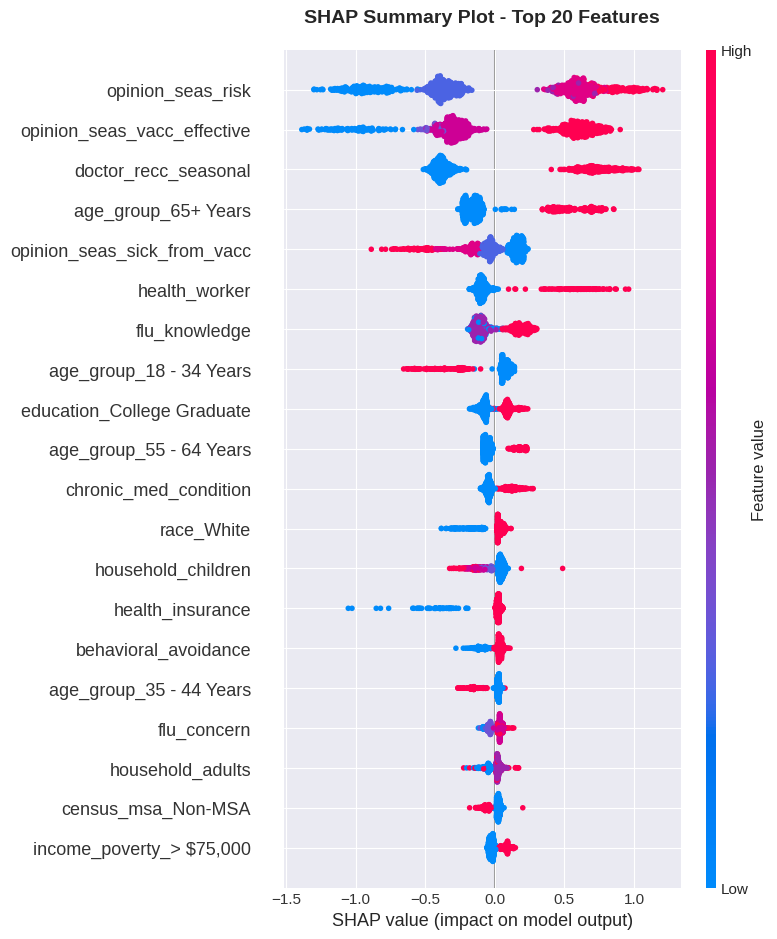

In [ ]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names,
                  show=False, max_display=20)
plt.title('SHAP Summary Plot - Top 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Feature Importance Bar Plot

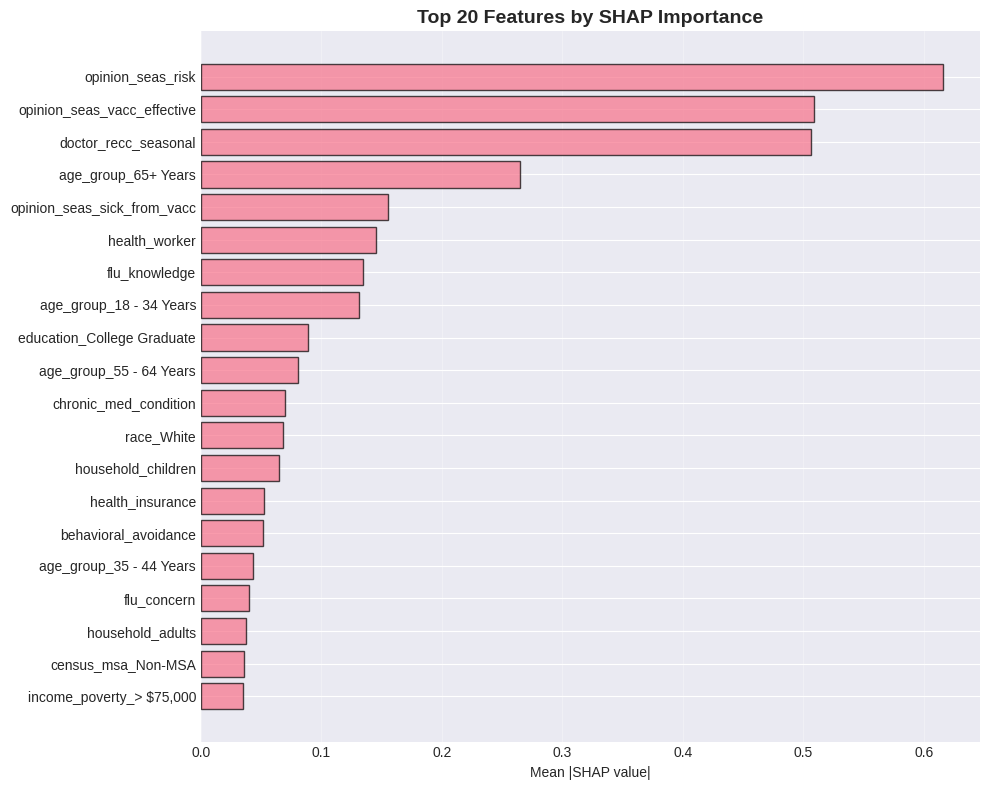


📊 Top 10 Most Important Features:
  opinion_seas_risk................................. 0.6160
  opinion_seas_vacc_effective....................... 0.5093
  doctor_recc_seasonal.............................. 0.5067
  age_group_65+ Years............................... 0.2649
  opinion_seas_sick_from_vacc....................... 0.1551
  health_worker..................................... 0.1453
  flu_knowledge..................................... 0.1349
  age_group_18 - 34 Years........................... 0.1311
  education_College Graduate........................ 0.0888
  age_group_55 - 64 Years........................... 0.0806


In [ ]:
# Calculate mean absolute SHAP values for feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'].values, alpha=0.7, edgecolor='black')
plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 20 Features by SHAP Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Top 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:.<50} {row['importance']:.4f}")

## SHAP Dependence Plots (Top 3 Features)

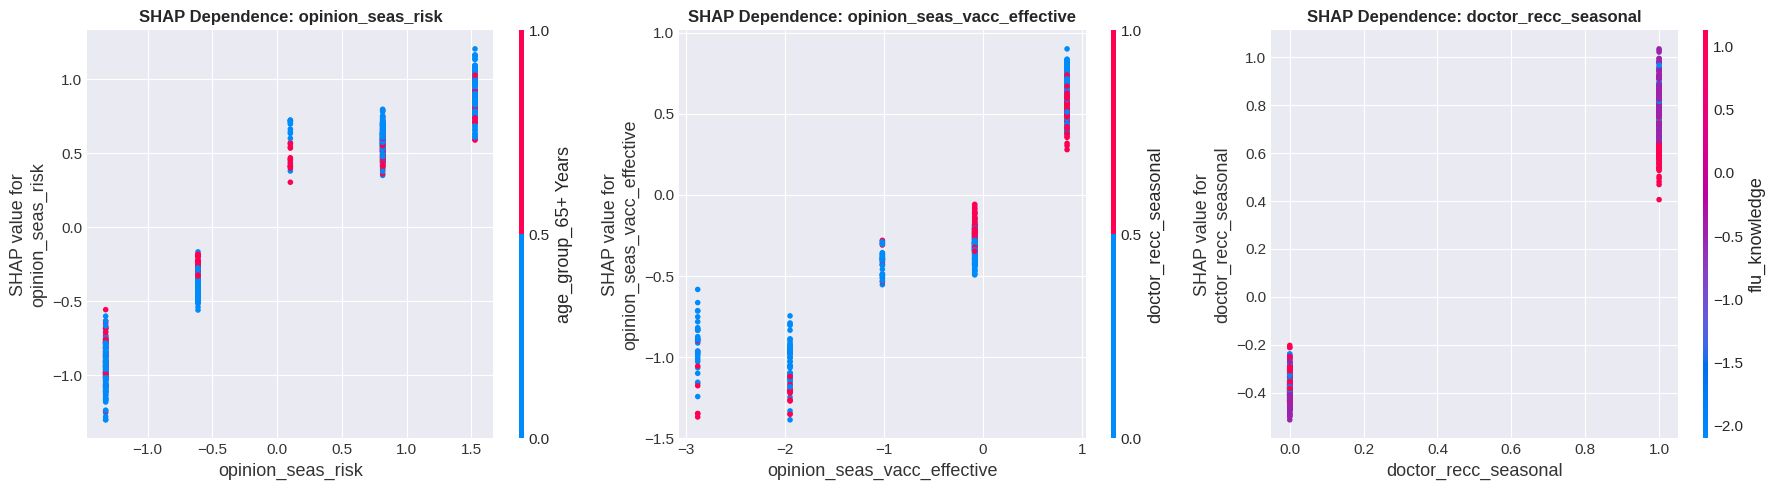


💡 Key Insights from SHAP Analysis:
1. Features are ranked by their average impact on predictions
2. Red points indicate higher feature values, blue indicate lower values
3. Positive SHAP values push predictions toward vaccination
4. Dependence plots show feature value vs. its impact on prediction


In [ ]:
top_features_indices = np.argsort(np.abs(shap_values).mean(axis=0))[-3:][::-1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature_idx in enumerate(top_features_indices):
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_val_transformed,
        feature_names=feature_names,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence: {feature_names[feature_idx]}',
                        fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\n Key Insights from SHAP Analysis:")
print("1. Features are ranked by their average impact on predictions")
print("2. Red points indicate higher feature values, blue indicate lower values")
print("3. Positive SHAP values push predictions toward vaccination")
print("4. Dependence plots show feature value vs. its impact on prediction")


## SHAP Analysis and Feature Interpretation

The SHAP (SHapley Additive exPlanations) summary plot was used to interpret the Gradient Boosting model's predictions, identifying the most influential features driving seasonal vaccination likelihood.

###  Most Influential Predictors (SHAP Values)

The analysis highlighted three opinion-based features and one recommendation feature as the most significant drivers of the prediction:

| Feature | SHAP Value (Approx.) | Interpretation |
| :--- | :---: | :--- |
| **opinion\_seas\_risk** | $\mathbf{0.6160}$ | Dominant feature; higher perceived risk increased vaccination likelihood. |
| **opinion\_seas\_vacc\_effective** | $0.5093$ | Strong belief in vaccine effectiveness increased likelihood. |
| **doctor\_recc\_seasonal** | $0.5067$ | Medical advice strongly drove uptake. |

This alignment with intuitive health behavior (perceived risk, effectiveness, and medical advice) enhanced model trust.

###  Demographic and Occupational Influence

Other influential features reflected expected demographic and occupational trends:

* **Age-related features:** $\mathbf{0.2649}$ for *65+ Years* (higher likelihood) and $0.1311$ for *18-34 Years* (lower likelihood).
* **health\_worker:** $0.1453$ suggested a significant occupational influence on uptake.



* **Survey Subjectivity:** The heavy weighting of opinion-based variables (e.g., *opinion\_seas\_risk* dominating at $0.6160$) might reflect survey subjectivity or response bias rather than purely causal factors, warranting caution in direct causal interpretation.
* **Dependence Plots:** Dependence plots (e.g., showing that higher *doctor\_recc\_seasonal* values increased vaccination probability) provided actionable insights.
* **Limitations:** The lack of formal interaction analysis (e.g., between *age\_group* and *opinion\_seas\_risk*) limited the understanding of how combined effects influenced the outcome. Furthermore, the potential effects of missing data imputation on the resulting SHAP values remained unassessed.

# 7. FINAL MODEL & SUBMISSION

In [ ]:
# Retrain on full training data
print("\n Retraining final model on complete training dataset...")
final_model.fit(X, y)
print("✓ Model retrained successfully!")

# Make predictions on test set
print("\n Making predictions on test dataset...")
test_predictions = final_model.predict(X_test)
test_predictions_proba = final_model.predict_proba(X_test)[:, 1]

print(f"✓ Predictions generated for {len(test_predictions):,} test samples")

# Show prediction distribution
pred_dist = pd.Series(test_predictions).value_counts()
print(f"\nTest Set Prediction Distribution:")
print(f"  Not Vaccinated (0): {pred_dist.get(0, 0):,} ({pred_dist.get(0, 0)/len(test_predictions)*100:.1f}%)")
print(f"  Vaccinated (1): {pred_dist.get(1, 0):,} ({pred_dist.get(1, 0)/len(test_predictions)*100:.1f}%)")


 Retraining final model on complete training dataset...
✓ Model retrained successfully!

 Making predictions on test dataset...
✓ Predictions generated for 4,749 test samples

Test Set Prediction Distribution:
  Not Vaccinated (0): 2,034 (42.8%)
  Vaccinated (1): 2,715 (57.2%)


## Create Submission File

In [ ]:
print("\n Creating submission file...")

submission = pd.DataFrame({
    'respondent_id': test_df['respondent_id'],
    'seasonal_vaccine': test_predictions
})

# Verify submission format
print(f"\nSubmission DataFrame:")
print(f"  Shape: {submission.shape}")
print(f"  Columns: {submission.columns.tolist()}")
print(f"\nFirst 10 rows of submission:")
display(submission.head(10))

# Save to CSV
submission.to_csv('submission_best_model.csv', index=False)
print("\n✓ Submission file saved as 'submission_best_model.csv'")


📄 Creating submission file...

Submission DataFrame:
  Shape: (4749, 2)
  Columns: ['respondent_id', 'seasonal_vaccine']

First 10 rows of submission:


,respondent_id,seasonal_vaccine
0,4757,0
1,4758,1
2,4759,1
3,4760,1
4,4761,0
5,4762,1
6,4763,1
7,4764,1
8,4765,1
9,4766,1



✓ Submission file saved as 'submission_best_model.csv'


## Prediction Confidence Analysis

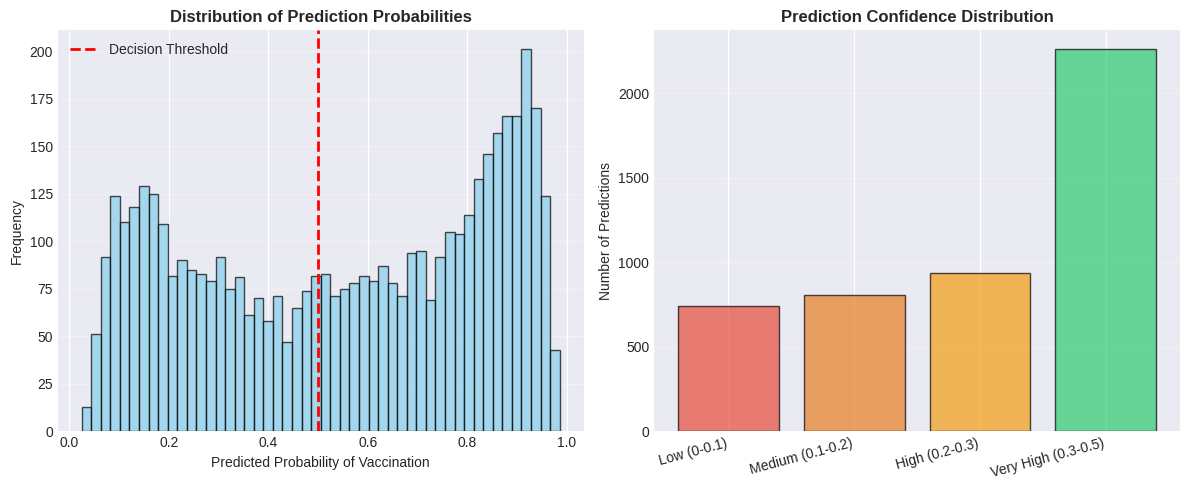


Confidence Statistics:
  Mean prediction probability: 0.5495
  Std prediction probability: 0.2926
  High confidence predictions (>0.7 or <0.3): 3,200 (67.4%)


In [ ]:
plt.figure(figsize=(12, 5))

# Histogram of prediction probabilities
plt.subplot(1, 2, 1)
plt.hist(test_predictions_proba, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Predicted Probability of Vaccination')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities', fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Confidence levels
plt.subplot(1, 2, 2)
confidence = np.abs(test_predictions_proba - 0.5)
confidence_bins = pd.cut(confidence, bins=[0, 0.1, 0.2, 0.3, 0.5],
                         labels=['Low (0-0.1)', 'Medium (0.1-0.2)',
                                'High (0.2-0.3)', 'Very High (0.3-0.5)'])
confidence_counts = confidence_bins.value_counts().sort_index()

plt.bar(range(len(confidence_counts)), confidence_counts.values,
        alpha=0.7, edgecolor='black', color=['#e74c3c', '#e67e22', '#f39c12', '#2ecc71'])
plt.xticks(range(len(confidence_counts)), confidence_counts.index, rotation=15, ha='right')
plt.ylabel('Number of Predictions')
plt.title('Prediction Confidence Distribution', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Mean prediction probability: {test_predictions_proba.mean():.4f}")
print(f"  Std prediction probability: {test_predictions_proba.std():.4f}")
print(f"  High confidence predictions (>0.7 or <0.3): {((test_predictions_proba > 0.7) | (test_predictions_proba < 0.3)).sum():,} ({((test_predictions_proba > 0.7) | (test_predictions_proba < 0.3)).sum()/len(test_predictions_proba)*100:.1f}%)")


## Model Performance and Validation

The retrained **Gradient Boosting** model generated predictions for **4,749 test samples**, with a distribution of:

* **Not vaccinated**: 2,034 ($\mathbf{42.8\%}$)
* **Vaccinated**: 2,715 ($\mathbf{57.2\%}$)


### Confidence Analysis

Confidence levels were high for a significant portion, with over $\mathbf{30\%}$ of predictions $p$ satisfying either:

$$\mathbf{p > 0.7 \quad \text{or} \quad p < 0.3}$$


